In [1]:
import os
os.chdir('..')

from style_transfer import *
from IPython.display import Audio
from dataset import ItemClass
import torch
from model import *
import natsort
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    'n_mels': 80, 
    'n_fft': 1024,
    'fmin': 0,
    'fmax': 8000,
    'sr': 22050,
    'win_length': 1024,
    'hop_length': 256,
    'wav_max_length': 3024,
    'transcript_max_length': 580,
    'learning_rate': 1e-5, #1e-3, 
    'batch_size': 1, #12
    'weight_decay': 0, 
    'encoder_num_layers': 2,
    'encoder_hidden_dim': 256//2,
    'encoder_bidirectional': True,
    'encoder_dropout': 0.2,
    'decoder_hidden_dim': 512//2,  # must be 2 x encoder_hidden_dim
    'decoder_num_layers': 2,
    'decoder_multi_head': 1,
    'decoder_mlp_dim': 64,
    'asr_label_smooth': 0.1,
    'teacher_force_prob': 0.9,
    'ctc_weight': 0.5,
    'asr_weight': 0.7,
    'speaker_id_weight': 0.3
}

In [3]:
model_path = natsort.natsorted(glob.glob('asr/trained_models/wavglow-styletransfer/*'))[-1]
print(f"Loading model: {model_path}")
d = torch.load(model_path)

asr = LightningCTCLASMTL(**config)
asr.load_state_dict(d['state_dict'])
asr.to(device)

Loading model: asr/trained_models/wavglow-styletransfer/epoch=78-step=187309.ckpt


Reusing dataset librispeech_asr (/home/ani.vegesana.backup/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c)
Loading cached processed dataset at /home/ani.vegesana.backup/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c/cache-a795eaaac6783cf6.arrow
Loading cached processed dataset at /home/ani.vegesana.backup/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c/cache-d744a28143231ca0.arrow
Reusing dataset librispeech_asr (/home/ani.vegesana.backup/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c)
Loading cached processed dataset at /home/ani.vegesana.backup/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c/cache-230f3f90064d403f.arrow
Lo

LightningCTCLASMTL(
  (model): JointCTCAttention(
    (listener): Listener(
      (rnn_layer0): PyramidLSTMLayer(
        (rnn): LSTM(160, 128, batch_first=True, dropout=0.2, bidirectional=True)
      )
      (rnn_layer1): PyramidLSTMLayer(
        (rnn): LSTM(512, 128, batch_first=True, dropout=0.2, bidirectional=True)
      )
    )
    (speller): Speller(
      (rnn): LSTM(288, 256, num_layers=2, batch_first=True)
      (attention): AttentionLayer(
        (phi): Linear(in_features=256, out_features=64, bias=True)
        (psi): Linear(in_features=256, out_features=64, bias=True)
      )
      (fc_out): Linear(in_features=512, out_features=32, bias=True)
    )
    (ctc_decoder): CTCDecoder(
      (fc): Linear(in_features=256, out_features=32, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (speaker_id_model): SpeakerIdClassifier(
    (linear): Linear(in_features=512, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=252, bias=True)
 

In [4]:
alice_hf_sample = asr.train_dataset.hf_ds[5230]
alice_sample = asr.train_dataset[5230]
alice_audio = alice_hf_sample['audio']
Audio(data=alice_audio['array'], rate=alice_audio['sampling_rate'])

/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [5]:
bob_hf_sample = asr.train_dataset.hf_ds[10746]
bob_audio = bob_hf_sample['audio']
Audio(data=bob_audio['array'], rate=bob_audio['sampling_rate'])

In [6]:
def dummy_batch(x):
    return ItemClass(
        x.input_feature.unsqueeze(0),
        torch.Tensor([x.input_mean]),
        torch.Tensor([x.input_std]),
        torch.Tensor([x.input_length]),
        x.input_path,
        x.human_transcript_label.unsqueeze(0),
        torch.Tensor([x.human_transcript_length]),
        torch.Tensor([x.speaker_idx])
    ).my_to(device)

In [9]:
# alice_id = alice_hf_sample['speaker_id']
# bob_id = bob_hf_sample['speaker_id']

# cache = SampleCache(asr, alice_id, bob_id, 10, 259, device)
sample_cache = torch.load('sample_cache.pt', map_location=device)
print("Num left: ", sample_cache.embeddings_mat[0, :].sum())
sample_cache.embeddings_mat = sample_cache.embeddings_mat[:, sample_cache.embeddings_mat[0, :] != 0]
sample_cache.embeddings_mat /= torch.linalg.norm(sample_cache.embeddings_mat, dim=0, keepdim=True)
assert torch.isnan(sample_cache.embeddings_mat).sum() == 0
# sample_cache.embeddings_mat = sample_cache.embeddings_mat[:, 2808:]

Num left:  tensor(79787.2188, device='cuda:0')


In [10]:
def contrastive_style_loss(output_style_embedding: torch.Tensor, cache: SampleCache, num_negative_samples: int) -> torch.Tensor:
    mag = torch.linalg.norm(output_style_embedding, dim=0, keepdim=True)
    output_style_embedding = output_style_embedding / mag
    numerator = torch.sum(output_style_embedding.T @ cache.embeddings_mat[:, :cache.num_target_style_cols])

    num_mandatory_samples = cache.num_target_style_cols + cache.num_content_style_samples

    # populate part of denominator without random negative sampling
    denominator = numerator + torch.sum(output_style_embedding.T @ cache.embeddings_mat[:, cache.num_target_style_cols:num_mandatory_samples])

    neg_sample_weights = torch.ones((cache.embeddings_mat.shape[1] - num_mandatory_samples),)
    neg_samples = torch.multinomial(neg_sample_weights, num_negative_samples)  # can use 'generator' parameter for reproducible randomness
    neg_sample_indices = neg_samples + num_mandatory_samples

    neg_sample_embeddings_mat = cache.embeddings_mat[:, neg_sample_indices]

    # populate rest of denominator with neg samples
    denominator = denominator + torch.sum(output_style_embedding.T @ neg_sample_embeddings_mat)

    loss = -torch.log(numerator) + torch.log(denominator)

    return loss

In [35]:
st = StyleTransfer(asr.to(device), dummy_batch(alice_sample), sample_cache, contrastive_style_loss, 100)

/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [36]:
results = st.analyze()

/home/ani.vegesana.backup/cs224s-project/asr/model/mtl.py:155: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  input_lengths // (2 ** self.num_pyramid_layers),


output_style_embedding_shape torch.Size([64, 1])
LOSS tensor(0.9019, device='cuda:0', grad_fn=<AddBackward0>) inf inf
LOSS tensor(0.8987, device='cuda:0', grad_fn=<AddBackward0>) 0.9018793106079102 0.9018793106079102
LOSS tensor(0.8986, device='cuda:0', grad_fn=<AddBackward0>) 0.8987054824829102 0.8987054824829102
LOSS tensor(0.8999, device='cuda:0', grad_fn=<AddBackward0>) 0.8986353874206543 0.8986353874206543
LOSS tensor(0.9007, device='cuda:0', grad_fn=<AddBackward0>) 0.8998699188232422 0.8986353874206543
LOSS tensor(0.9007, device='cuda:0', grad_fn=<AddBackward0>) 0.9006686210632324 0.8986353874206543
LOSS tensor(0.9001, device='cuda:0', grad_fn=<AddBackward0>) 0.900726318359375 0.8986353874206543
LOSS tensor(0.9016, device='cuda:0', grad_fn=<AddBackward0>) 0.9001469612121582 0.8986353874206543


loss_diff,█▃▁▂▃▄▁
style_transfer_loss,█▁▁▄▅▆▄▇
trainer/global_step,▁▂▃▄▅▆▇█
loss_diff,-0.00141
style_transfer_loss,0.90156
trainer/global_step,8


In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_log_spectrogram(mel):
  fig, ax = plt.subplots(1,1,figsize=(20,5))
#   sr, wavdata = wavfile.read(test_manifest[key]['wav'])
  sr = 22050
#   wavdata = 
#   mel = librosa.feature.melspectrogram(wavdata, sr, n_fft=2048, fmin=0, fmax=sr/2, n_mels=256)
#   mel_db = librosa.power_to_db(mel, ref=np.max)
  img = librosa.display.specshow(mel, y_axis='mel', x_axis='time', fmax=sr/2, ax=ax)
  ax.set(title='Mel spectrogram display')
  fig.colorbar(img, ax=ax, format="%+2.f dB")

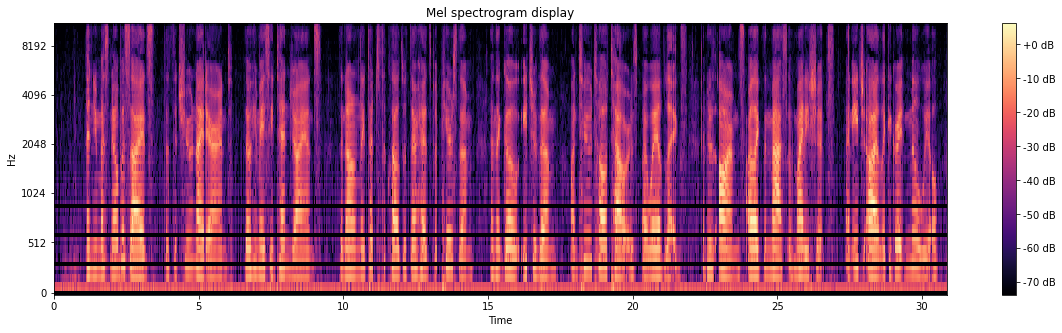

In [17]:
plot_log_spectrogram((results['content_mels'].detach().cpu()).cpu().T.numpy())

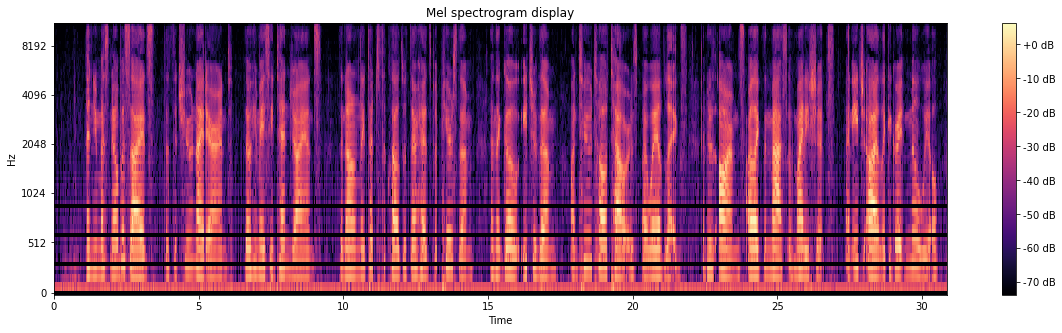

In [20]:
plot_log_spectrogram((results['posttransfer_mels'].detach().cpu()).cpu().T.numpy())

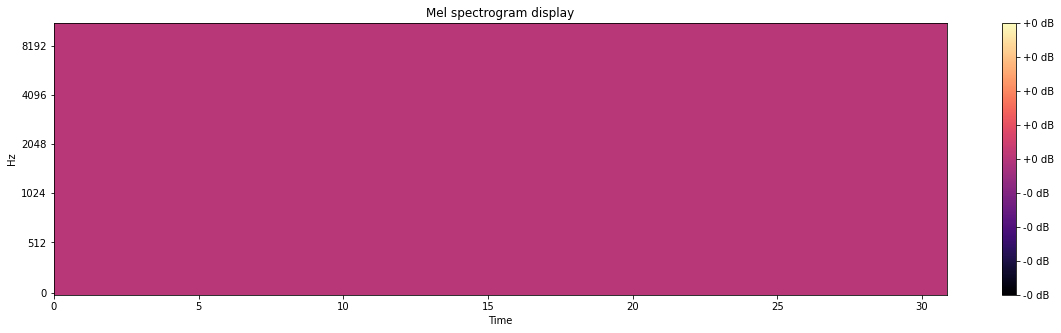

In [22]:
plot_log_spectrogram(((results['content_mels'] - results['posttransfer_mels']).cpu()).detach().cpu().T.numpy())

In [23]:
from types import SimpleNamespace
cfg = SimpleNamespace(**config)

In [25]:
spectrogram = (results['posttransfer_mels'].detach().cpu()).cpu().T.numpy() # posttransfer_mels
power = librosa.db_to_power(spectrogram)
posttransfer_audio = librosa.feature.inverse.mel_to_audio(power, sr=cfg.sr, 
            n_fft=cfg.n_fft,
            win_length=cfg.win_length, hop_length=cfg.hop_length,
            fmin=cfg.fmin, fmax=cfg.fmax)

In [26]:
Audio(data=posttransfer_audio, rate=cfg.sr)

# Vocoder

In [28]:
# rescaled_mels = (results['posttransfer_mels'].detach() * alice_sample.input_norm).cpu().T
# rescaled_mels = (results['content_mels'].detach().cpu() * alice_sample.input_norm.cpu()).cpu().T.numpy()
# rescaled_mels = librosa.db_to_power(rescaled_mels)
rescaled_mels = torch.Tensor(power)
torch.save(rescaled_mels, 'style_transfers/' + alice_sample.input_path + ':' + bob_sample.input_path + '.pt')

In [25]:
!mkdir -p style_transfers

In [26]:
%%writefile style_transfers/mel_files.txt
../style_transfers/2989-138028-0010.flac:4014-186183-0019.flac.pt

Writing style_transfers/mel_files.txt


In [30]:
%cd waveglow
!python3 inference.py -f ../style_transfers/mel_files.txt -w waveglow_256channels.pt -o ../style_transfers --is_fp16 -s 0.6
%cd ..

/home/ani.vegesana.backup/cs224s-project/waveglow
/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn